###### Assignemnt: Bayesian Convolutional Network with pyro

**Objective:** Implement, train and evaluate a Bayesian Lenet5 model on the MNIST dataset. 

**Requirements:**

- Use `torchvision.datasets.MNIST` to obtain the training and test data. Only use digits 4 and 9 (discard the others)
- Implement a bayesian neural network using `pyro` based on the Lenet5 convolutional architecture
- Use a bernoulli likelihood, a diagonal normal for the approximate posterior and a diagonal normal prior. Use the Mean Field Trace ELBO
- Evaluate the performance of the BNN using precision/recall curves and uncertainty calibration plots [2, 3, 4]
- Study the influence of the scale of the prior and the initial scale of the approximate posterior
- Compare your best bayesian model with a Deterministic Lenet5 
- Discuss your results! 


**References**
1. https://www.kaggle.com/blurredmachine/lenet-architecture-a-complete-guide
2. https://arxiv.org/pdf/1703.04977.pdf (Section 5.1)
3. https://arxiv.org/pdf/2007.06823.pdf (Section 9)
4. https://arxiv.org/pdf/1706.04599.pdf 

**Deadline**

17:30, June 16th, 2021


In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import torch

from torch.utils.data import Subset


import torch.nn as nn
import torch.nn.functional as F
import pyro
display(pyro.__version__)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

def getIdxForLabels(dataset, labels):
    mask = dataset.targets == labels[0]
    for label in labels[1:]:
        mask |= dataset.targets == label
    return np.where(mask)
def renameLabelsInOrder(dataset, labels):
    i=1
    dataset.targets[dataset.targets == 4] = 0
    for label in labels[1:]:
        dataset.targets[dataset.targets == 9] = i
        i+=1

import torchvision
mnist_train = torchvision.datasets.MNIST('./datasets', train=True, download=True,
                                        transform=torchvision.transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST('./datasets', train=False, download=True,
                                        transform=torchvision.transforms.ToTensor())
train_idx = getIdxForLabels(mnist_train, [4, 9])
test_idx = getIdxForLabels(mnist_test, [4, 9])

train_dataset = Subset(mnist_train, train_idx[0])
test_dataset = Subset(mnist_test, test_idx[0])

renameLabelsInOrder(mnist_train, [4, 9])
renameLabelsInOrder(mnist_test, [4, 9])


print(len(train_dataset), " elements for training.")
print(len(test_dataset), " elements for testing.")

'1.6.0'

11791  elements for training.
1991  elements for testing.


<IPython.core.display.Javascript object>


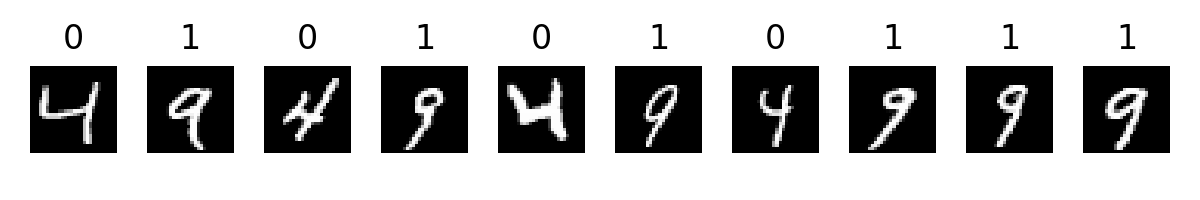

In [2]:
fig, ax = plt.subplots(1, 10, figsize=(6, 1), tight_layout=True)
for i in range(10):
    image, label = train_dataset[i]
    ax[i].imshow(image.numpy()[0, :, :], cmap=plt.cm.Greys_r)
    ax[i].axis('off')
    ax[i].set_title(label)

In [146]:
from torch.utils.data import DataLoader, SubsetRandomSampler

np.random.seed(0)
idx = list(range(len(train_dataset)))
np.random.shuffle(idx)
split = int(0.85*len(idx))

train_loader = DataLoader(train_dataset, batch_size=128, drop_last=False,
                          sampler=SubsetRandomSampler(idx[:split]))

valid_loader = DataLoader(train_dataset, batch_size=128, drop_last=False,
                          sampler=SubsetRandomSampler(idx[split:]))

test_loader = DataLoader(test_dataset, batch_size=64, drop_last=False,
                          shuffle=True)

<IPython.core.display.Javascript object>


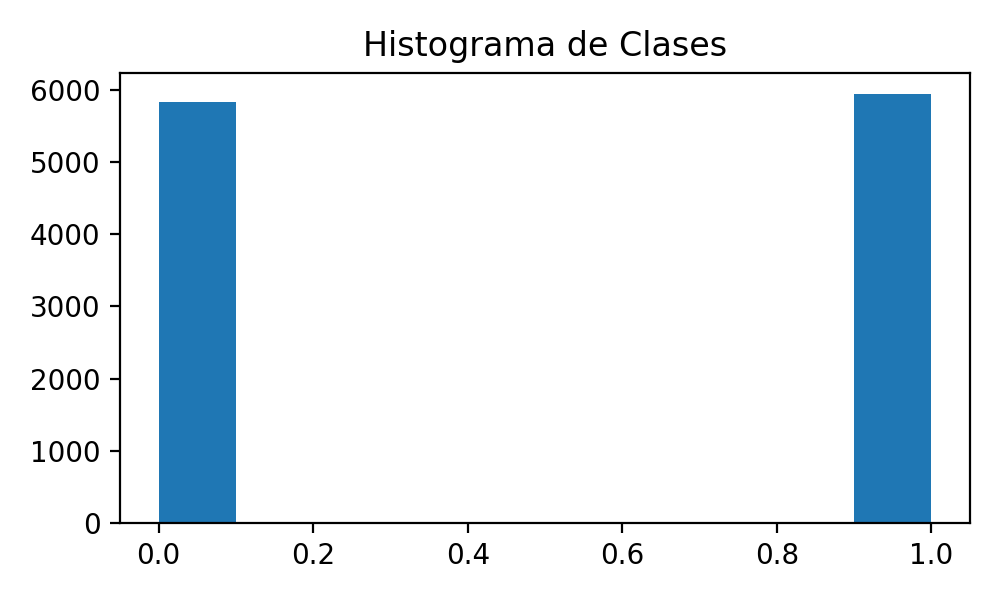

Text(0.5, 1.0, 'Histograma de Clases')

In [4]:
fig, ax = plt.subplots(figsize=(5, 3), tight_layout=True)
ax.hist(train_dataset.dataset.targets[train_dataset.indices].numpy() )
ax.set_title("Histograma de Clases")

In [365]:
class Lenet5Deterministic(nn.Module):
    def __init__(self):
        super(Lenet5Deterministic, self).__init__()
    
        self.conv1 = nn.Conv2d(1, 6, 5, stride=1)
        self.conv2 = nn.Conv2d(6, 16, 5, stride=1)
        ## Kernel size changed to 4 to fit data (original Lenet was designed for 32x32x1 imgs)
        self.conv3 = nn.Conv2d(16, 120, 4, stride=1)

        self.fc1 = nn.Linear(120, 84)  
        self.fc2 = nn.Linear(84, 1)
        
        self.activation = nn.Tanh()
        self.output = nn.Sigmoid()
        
    def forward(self, x):
        #print(x.shape)
        x = F.avg_pool2d(self.activation(self.conv1(x)), 2, stride=2)
        #print(x.shape)
        x = F.avg_pool2d(self.activation(self.conv2(x)), 2, stride=2)
        #print(x.shape)
        x = self.activation(self.conv3(x))
        #print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        #print(x.shape)
        x = self.activation(self.fc1(x))
        #print(x.shape)
                
        x = self.output(self.fc2(x))
        #x = torch.tanh(self.fc2(x))
        
        x = x.squeeze(1)

        return x

In [366]:
learning_rate = 1e-3
model = Lenet5Deterministic()

for batch, (X, y) in enumerate(train_loader):
    print(model(X))
    print(y)
    break

tensor([0.5042, 0.4996, 0.5047, 0.4991, 0.5008, 0.4966, 0.5077, 0.4961, 0.5042,
        0.4942, 0.5022, 0.4964, 0.5027, 0.5025, 0.5046, 0.5092, 0.4971, 0.5015,
        0.4973, 0.5019, 0.5011, 0.4989, 0.4995, 0.5022, 0.5000, 0.4959, 0.5048,
        0.4974, 0.5012, 0.4999, 0.4975, 0.4971, 0.4996, 0.4997, 0.5020, 0.4995,
        0.4984, 0.4982, 0.4994, 0.5022, 0.5052, 0.5005, 0.5010, 0.4980, 0.4985,
        0.5004, 0.5021, 0.4992, 0.4969, 0.4968, 0.5002, 0.4971, 0.5007, 0.5031,
        0.4975, 0.5043, 0.4999, 0.4960, 0.4969, 0.4989, 0.4998, 0.5079, 0.5033,
        0.4967, 0.4979, 0.4995, 0.5071, 0.4962, 0.5011, 0.5028, 0.4987, 0.5011,
        0.5063, 0.5002, 0.5064, 0.4992, 0.4973, 0.5025, 0.4977, 0.4989, 0.4998,
        0.4959, 0.5019, 0.5016, 0.4936, 0.5007, 0.5047, 0.4996, 0.5018, 0.5049,
        0.5019, 0.5000, 0.5006, 0.4970, 0.5003, 0.4962, 0.4979, 0.5012, 0.4974,
        0.4965, 0.4983, 0.5005, 0.4992, 0.4969, 0.4983, 0.4982, 0.5014, 0.5038,
        0.5026, 0.5031, 0.5055, 0.5020, 

In [367]:
loss = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train_loop(dataloader, model, loss_fn, optimizer, n_samples):
    size = n_samples
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        # Compute prediction and loss
        y = y.type(torch.float)
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 15 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            

def valid_loop(dataloader, model, loss_fn, n_samples):
    size = n_samples
    print(size)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            y = y.type(torch.float)
            test_loss += loss_fn(pred, y).item()
            
            correct += (torch.round(pred) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print(f"\rValidation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    print(size)
    with torch.no_grad():
        for X, y in dataloader:
            y = y.type(torch.float)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [368]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss, optimizer, split)
    valid_loop(valid_loader, model, loss, len(train_loader.dataset)-split)
test_loop(test_loader, model, loss)


print("Done!")

Epoch 1
-------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

loss: 0.690781  [    0/10022]
loss: 0.430491  [ 1920/10022]
loss: 0.201966  [ 3840/10022]
loss: 0.139548  [ 5760/10022]
loss: 0.148424  [ 7680/10022]
loss: 0.104427  [ 9600/10022]
1769
Validation Error: 
 Accuracy: 95.8%, Avg loss: 0.000936 

Epoch 2
-------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

loss: 0.193644  [    0/10022]
loss: 0.239772  [ 1920/10022]
loss: 0.125169  [ 3840/10022]
loss: 0.117124  [ 5760/10022]
loss: 0.122911  [ 7680/10022]
loss: 0.108492  [ 9600/10022]
1769
Validation Error: 
 Accuracy: 97.2%, Avg loss: 0.000650 

Epoch 3
-------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

loss: 0.052953  [    0/10022]
loss: 0.147539  [ 1920/10022]
loss: 0.062685  [ 3840/10022]
loss: 0.078058  [ 5760/10022]
loss: 0.041700  [ 7680/10022]
loss: 0.092850  [ 9600/10022]
1769
Validation Error: 
 Accuracy: 97.9%, Avg loss: 0.000537 

Epoch 4
-------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

loss: 0.093238  [    0/10022]
loss: 0.069313  [ 1920/10022]
loss: 0.071494  [ 3840/10022]
loss: 0.071614  [ 5760/10022]
loss: 0.018015  [ 7680/10022]
loss: 0.032437  [ 9600/10022]
1769
Validation Error: 
 Accuracy: 98.2%, Avg loss: 0.000457 

Epoch 5
-------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

loss: 0.107010  [    0/10022]
loss: 0.060697  [ 1920/10022]
loss: 0.052914  [ 3840/10022]
loss: 0.040826  [ 5760/10022]
loss: 0.030200  [ 7680/10022]
loss: 0.125692  [ 9600/10022]
1769
Validation Error: 
 Accuracy: 98.5%, Avg loss: 0.000382 

Epoch 6
-------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

loss: 0.062577  [    0/10022]
loss: 0.045342  [ 1920/10022]
loss: 0.031966  [ 3840/10022]
loss: 0.042806  [ 5760/10022]
loss: 0.051235  [ 7680/10022]
loss: 0.029578  [ 9600/10022]
1769
Validation Error: 
 Accuracy: 98.2%, Avg loss: 0.000406 

Epoch 7
-------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

loss: 0.128099  [    0/10022]
loss: 0.048089  [ 1920/10022]
loss: 0.028586  [ 3840/10022]
loss: 0.023676  [ 5760/10022]
loss: 0.126171  [ 7680/10022]
loss: 0.040594  [ 9600/10022]
1769
Validation Error: 
 Accuracy: 98.5%, Avg loss: 0.000364 

Epoch 8
-------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

loss: 0.016727  [    0/10022]
loss: 0.037894  [ 1920/10022]
loss: 0.091618  [ 3840/10022]
loss: 0.058778  [ 5760/10022]
loss: 0.007644  [ 7680/10022]
loss: 0.067357  [ 9600/10022]
1769
Validation Error: 
 Accuracy: 98.4%, Avg loss: 0.000421 

Epoch 9
-------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

loss: 0.014905  [    0/10022]
loss: 0.015121  [ 1920/10022]
loss: 0.041043  [ 3840/10022]
loss: 0.088426  [ 5760/10022]
loss: 0.008807  [ 7680/10022]
loss: 0.151677  [ 9600/10022]
1769
Validation Error: 
 Accuracy: 98.2%, Avg loss: 0.000432 

Epoch 10
-------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

loss: 0.075052  [    0/10022]
loss: 0.018272  [ 1920/10022]
loss: 0.053080  [ 3840/10022]
loss: 0.064671  [ 5760/10022]
loss: 0.017714  [ 7680/10022]
loss: 0.005804  [ 9600/10022]
1769
Validation Error: 
 Accuracy: 98.6%, Avg loss: 0.000367 

1991
Test Error: 
 Accuracy: 98.8%, Avg loss: 0.000525 

Done!


In [369]:
import pyro
from pyro.nn import PyroSample, PyroModule
import pyro.distributions as dists 
display(pyro.__version__)
pyro.set_rng_seed(12345) # Fo

'1.6.0'

In [592]:
class Lenet5Bayesian(PyroModule):
    def __init__(self, prior_scale=1., isFEBayesian=True, prior_scaleFE = 4.):
        super(Lenet5Bayesian, self).__init__()
        prior = dists.Normal(0, prior_scale)
        priorFE = dists.Normal(0, prior_scaleFE)
        
        if isFEBayesian:
            self.conv1 = PyroModule[nn.Conv2d](1, 6, 5, stride=1)
            self.conv1.weight = PyroSample(priorFE.expand([6, 1, 5, 5]).to_event(4))
            self.conv1.bias = PyroSample(priorFE.expand([6]).to_event(1))

            self.conv2 = PyroModule[nn.Conv2d](6, 16, 5, stride=1)   
            self.conv2.weight = PyroSample(priorFE.expand([16, 6, 5, 5]).to_event(4))
            self.conv2.bias = PyroSample(priorFE.expand([16]).to_event(1))

            self.conv3 = PyroModule[nn.Conv2d](16, 120, 4, stride=1)
            self.conv3.weight = PyroSample(priorFE.expand([120, 16, 4, 4]).to_event(4))
            self.conv3.bias = PyroSample(priorFE.expand([120]).to_event(1))
        else: 
            self.conv1 = nn.Conv2d(1, 6, 5, stride=1)
            self.conv2 = nn.Conv2d(6, 16, 5, stride=1)   
            ## Kernel size changed to 4 to fit data (original Lenet was designed for 32x32x1 imgs)
            self.conv3 = nn.Conv2d(16, 120, 4, stride=1)
        
        self.fc1 = PyroModule[nn.Linear](120, 84)  
        self.fc1.weight = PyroSample(prior.expand([84, 120]).to_event(2))
        self.fc1.bias = PyroSample(prior.expand([84]).to_event(1))

        
        self.fc2 = PyroModule[nn.Linear](84, 1)
        self.fc2.weight = PyroSample(prior.expand([1, 84]).to_event(2))
        self.fc2.bias = PyroSample(prior.expand([1]).to_event(1))
        
        self.output = nn.Sigmoid()
        self.activation = nn.Tanh()

        
    def forward(self, x, y=None):
        x = F.avg_pool2d(self.activation(self.conv1(x)), 2, stride=2)
        x = F.avg_pool2d(self.activation(self.conv2(x)), 2, stride=2)
        x = self.activation(self.conv3(x))
        
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension

        x = self.activation(self.fc1(x))
        x = self.output(self.fc2(x))
        #x = self.fc2(x)
        f = x.squeeze(1)

        #print(f.shape)
        with pyro.plate("data", f.shape[0]):
            loc = pyro.deterministic("k", f, event_dim=0)   
            obs = pyro.sample("obs", dists.Bernoulli(probs=loc), obs=y) #likelihood
        
        return f

In [608]:
model2 = Lenet5Bayesian(prior_scale=50., isFEBayesian=True, prior_scaleFE=50.)
with torch.no_grad():
    for X, y in train_loader:
        pred = model2(X, y)

        print(pred.round())
        print(y)
        break

tensor([0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
        0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
        1., 0.])
tensor([0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
        0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
        0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
        1, 1, 0, 1, 0, 

<IPython.core.display.Javascript object>


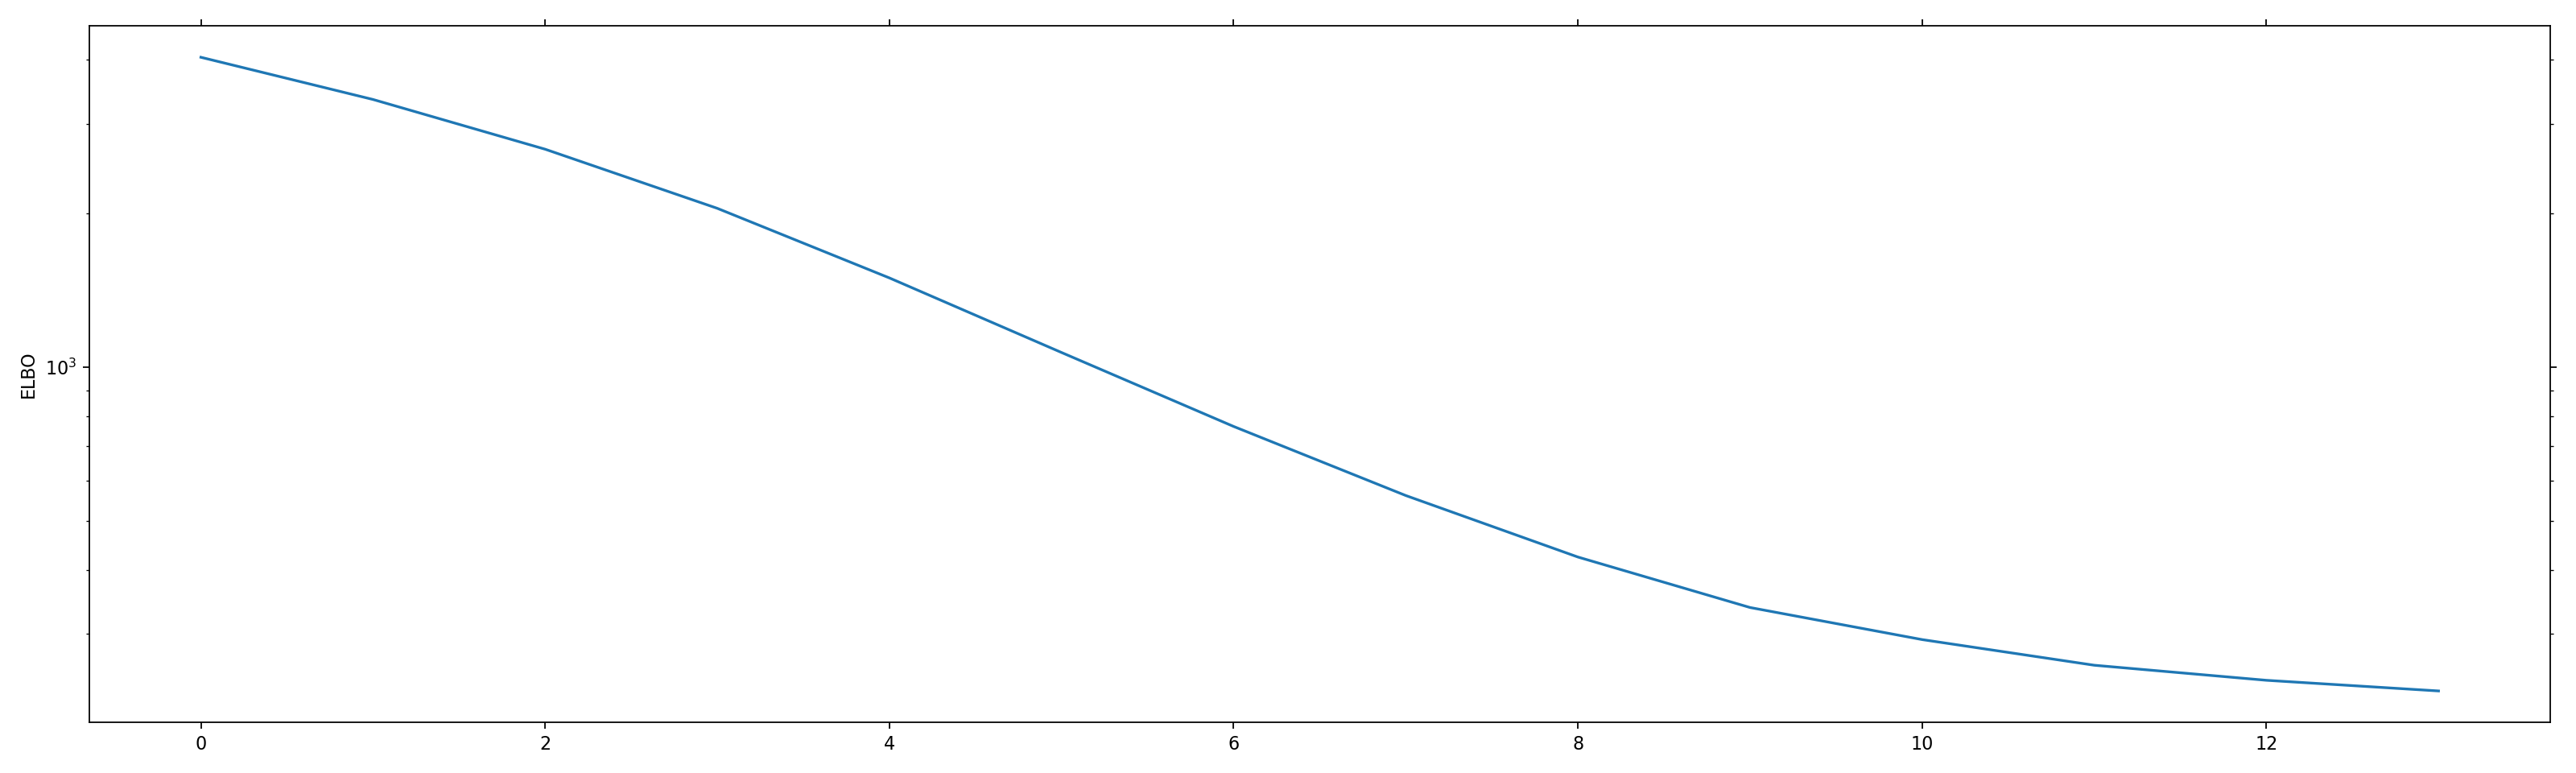

In [609]:
pyro.enable_validation(True)
fig, ax = plt.subplots(figsize=(10, 3), tight_layout=True, dpi=80)

def update_plot(k, epoch_loss):
    ax.cla()
    ax.plot(range(k), epoch_loss[:k])
    ax.set_yscale('log')
    ax.set_ylabel('ELBO')
    #ax[1].cla()
    #ax[1].plot(x, y, 'k.');
    #med = np.median(samples, axis=[0])
    #qua = np.quantile(samples, (0.05, 0.95), axis=0)
    #ax[1].plot(x_test.numpy()[:, 0], med)
    #ax[1].fill_between(x_test.numpy()[:, 0], qua[0], qua[1], alpha=0.5)
    fig.canvas.draw()
#print(pyro.poutine.trace(model2).get_trace(x_torch, y_torch).format_shapes())

In [610]:
# Turn this on for additional debugging
pyro.enable_validation(False) 
pyro.set_rng_seed(123)
pyro.clear_param_store() 
# Create a guide
from pyro.infer.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model2, init_scale=5e-1)

# Create SVI object
svi = pyro.infer.SVI(model2, guide, 
                     optim=pyro.optim.ClippedAdam({'lr':1e-2}), # Optimizer
                     loss=pyro.infer.TraceMeanField_ELBO()) # Loss function 

epoch_loss = np.zeros(shape=(15,))
for k in tqdm(range(len(epoch_loss))):

    for batch, (X, y) in enumerate(train_loader):
        loss = svi.step(x=X, y=y.type(torch.float)) # Actual training step
        epoch_loss[k] = loss / len(X)

        if batch % 30 == 0:
            update_plot(k, epoch_loss)        
            

  0%|          | 0/15 [00:00<?, ?it/s]

In [612]:
predictive = pyro.infer.Predictive(model2, guide=guide, num_samples=100)
print(predictive(X)['k'].detach().numpy().shape)
print(y)
for X, y in test_loader:
    print(np.mean(predictive(X)['obs'].detach().numpy(), axis=0))
    break

(100, 64)
tensor([1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0])
[0.46 0.57 0.52 0.5  0.53 0.56 0.59 0.54 0.47 0.59 0.46 0.54 0.51 0.53
 0.48 0.48 0.51 0.52 0.42 0.55 0.54 0.54 0.54 0.52 0.52 0.49 0.41 0.48
 0.55 0.6  0.58 0.49 0.47 0.45 0.58 0.44 0.52 0.52 0.48 0.43 0.45 0.49
 0.44 0.46 0.51 0.41 0.51 0.56 0.41 0.51 0.5  0.44 0.49 0.41 0.5  0.55
 0.55 0.57 0.47 0.6  0.59 0.51 0.51 0.51]


In [574]:
predictive = pyro.infer.Predictive(model2, guide=guide, num_samples=100)

res = 0
total = 0
errors= []
with torch.no_grad():
    for X, y in tqdm(test_loader):
        #print(np.mean(predictive(X)['obs'].detach().numpy().shape))
        #print(torch.round(torch.mean(predictive(X)['obs'].detach())), "of", y.item())
        hitormiss = (predictive(X)['k'].detach().mean(dim=0).round() == y)
        res += hitormiss.sum()
        total += X.shape[0]
        fails = np.where(hitormiss == False)
        #print(X[fails].shape)
        for error in X[fails]:
            errors.append(error)
        #sum = (torch.round(torch.mean(predictive(X)['obs'].detach(), dim=1)) ==  y).sum()
        #res += sum
            #res+=1
        #print(X[torch.round(torch.mean(predictive(X)['obs'].detach())) !=  y].shape)
        #errors.append(X[torch.round(torch.mean(predictive(X)['obs'].detach(), dim=0)) !=  y, :, : ,:])
        #total +=64
        #for k, v in predictive(X, None).items():
        #    print(k, v.shape)
        print(res/total*100)


  0%|          | 0/32 [00:00<?, ?it/s]

IndexError: index 2 is out of bounds for dimension 1 with size 1

In [563]:
print(res/total*100)

tensor(52.9884)


212


<IPython.core.display.Javascript object>


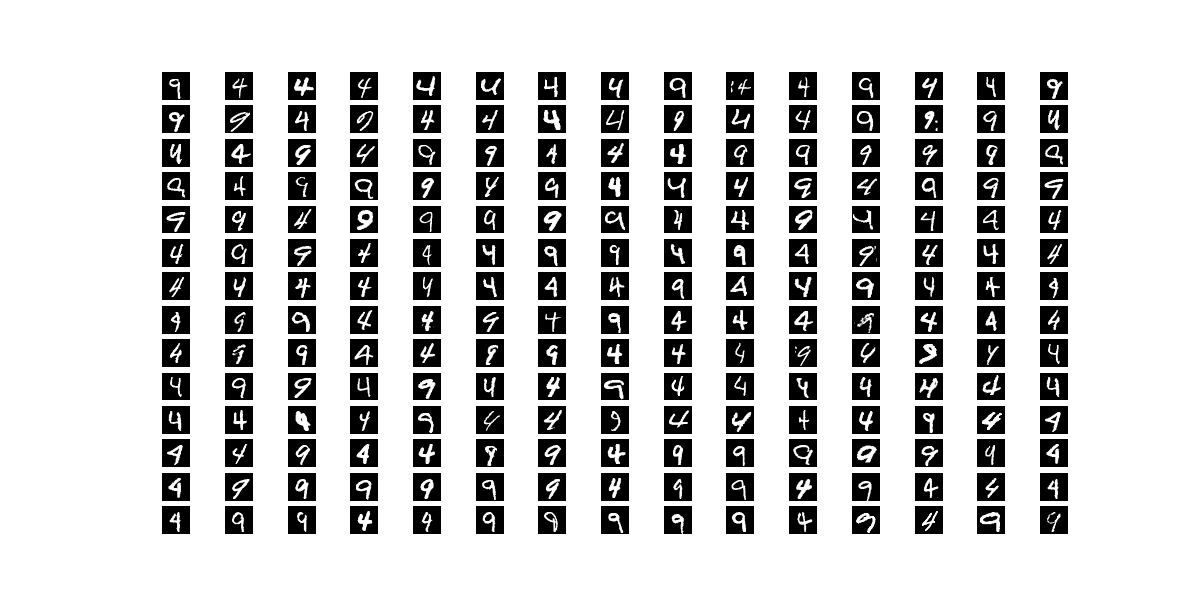

In [503]:
nerrors = len(errors)
print(nerrors)
rows = int(np.floor(np.sqrt(nerrors)))
cols = nerrors//rows
fig, ax = plt.subplots(rows, cols, figsize=(6, 3), tight_layout=False)
for i in range(rows):
    for j in range(cols):
        image = errors[i*rows+j].squeeze(0).squeeze(0).unsqueeze(2)
        ax[i,j].imshow(image.numpy(), cmap=plt.cm.Greys_r)
        ax[i,j].axis('off')
